# House Price Regression
### Predição de valores de casas



In [1]:
# === 1. Importações ===
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from joblib import dump
import warnings
warnings.filterwarnings('ignore')


In [2]:
# === 2. Carregamento do Dataset ===
try:
    import kagglehub
    path = kagglehub.dataset_download("prokshitha/home-value-insights")
    df = pd.read_csv(os.path.join(path, 'house_price_regression_dataset.csv'))
    origem = "KaggleHub"
except Exception:
    print("⚠️ kagglehub não disponível.")
    df = pd.read_csv('house_price_regression_dataset.csv')
    origem = "local"

print(f"✅ Dataset carregado ({origem}) - {df.shape[0]} linhas, {df.shape[1]} colunas")
display(df.head())
df.info()

✅ Dataset carregado (KaggleHub) - 1000 linhas, 8 colunas


,Square_Footage,Num_Bedrooms,Num_Bathrooms,Year_Built,Lot_Size,Garage_Size,Neighborhood_Quality,House_Price
0,1360,2,1,1981,0.599637,0,5,2.623829e+05
1,4272,3,3,2016,4.753014,1,6,9.852609e+05
2,3592,1,2,2016,3.634823,0,9,7.779774e+05
3,966,1,2,1977,2.730667,1,8,2.296989e+05
4,4926,2,1,1993,4.699073,0,8,1.041741e+06


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Square_Footage        1000 non-null   int64  
 1   Num_Bedrooms          1000 non-null   int64  
 2   Num_Bathrooms         1000 non-null   int64  
 3   Year_Built            1000 non-null   int64  
 4   Lot_Size              1000 non-null   float64
 5   Garage_Size           1000 non-null   int64  
 6   Neighborhood_Quality  1000 non-null   int64  
 7   House_Price           1000 non-null   float64
dtypes: float64(2), int64(6)
memory usage: 62.6 KB



 Estatísticas Descritivas:


,Square_Footage,Num_Bedrooms,Num_Bathrooms,Year_Built,Lot_Size,Garage_Size,Neighborhood_Quality,House_Price
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1.000000e+03
mean,2815.422000,2.990000,1.973000,1986.550000,2.778087,1.022000,5.615000,6.188610e+05
std,1255.514921,1.427564,0.820332,20.632916,1.297903,0.814973,2.887059,2.535681e+05
min,503.000000,1.000000,1.000000,1950.000000,0.506058,0.000000,1.000000,1.116269e+05
25%,1749.500000,2.000000,1.000000,1969.000000,1.665946,0.000000,3.000000,4.016482e+05
50%,2862.500000,3.000000,2.000000,1986.000000,2.809740,1.000000,6.000000,6.282673e+05
75%,3849.500000,4.000000,3.000000,2004.250000,3.923317,2.000000,8.000000,8.271413e+05
max,4999.000000,5.000000,3.000000,2022.000000,4.989303,2.000000,10.000000,1.108237e+06


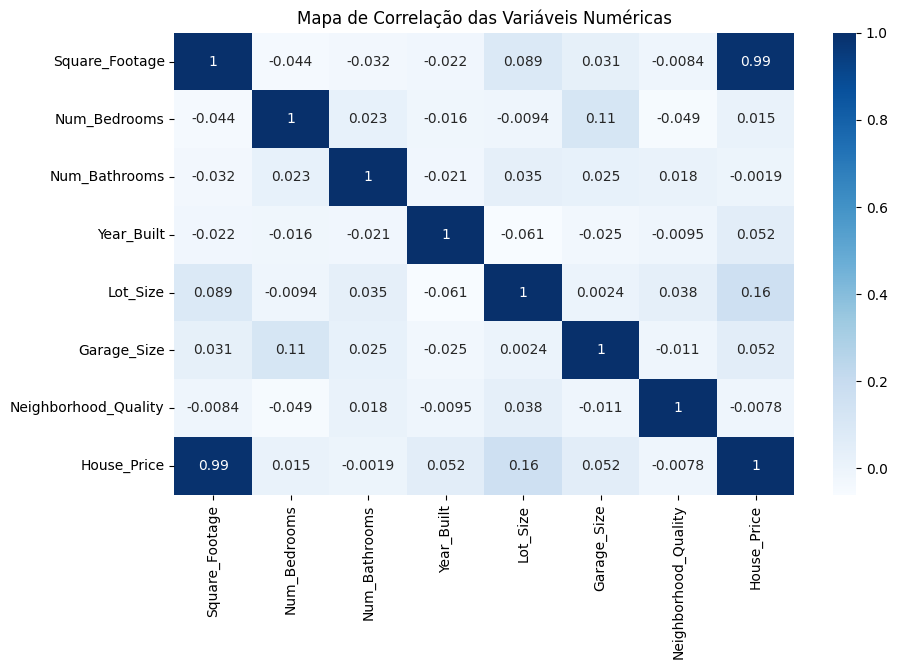

In [3]:
# === 3. Análise Exploratória de Dados ===
print("\n Estatísticas Descritivas:")
display(df.describe())

# Mapa de correlação
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='Blues')
plt.title('Mapa de Correlação das Variáveis Numéricas')
plt.show()


In [4]:
# === Top 5 e Bottom 5 valores do dataset ===

coluna_preco = 'House_Price'  

# Ordenar o dataset pelo preço
df_ordenado = df.sort_values(by=coluna_preco, ascending=True)

# 5 mais baratos
print("🏠 5 imóveis mais baratos:")
display(df_ordenado.head(5))

# 5 mais caros
print("\n💎 5 imóveis mais caros:")
display(df_ordenado.tail(5))



🏠 5 imóveis mais baratos:


,Square_Footage,Num_Bedrooms,Num_Bathrooms,Year_Built,Lot_Size,Garage_Size,Neighborhood_Quality,House_Price
666,555,2,1,1962,1.552536,0,2,111626.853424
868,626,2,1,1959,1.178094,2,1,113576.512370
951,554,3,2,1954,1.546436,2,6,120795.552367
271,627,2,1,1967,2.637279,0,2,126097.927163
751,509,5,3,1957,1.438648,1,1,140538.083185



💎 5 imóveis mais caros:


,Square_Footage,Num_Bedrooms,Num_Bathrooms,Year_Built,Lot_Size,Garage_Size,Neighborhood_Quality,House_Price
219,4933,3,1,2015,4.769350,2,7,1.096158e+06
364,4952,4,3,1995,4.725027,2,9,1.099212e+06
232,4996,1,3,2014,4.252064,1,1,1.102534e+06
81,4974,5,2,2000,3.709561,2,10,1.107045e+06
921,4922,4,1,2018,4.233753,2,2,1.108237e+06


As variáveis numéricas usadas na análise são:

['Square_Footage', 'Num_Bedrooms', 'Num_Bathrooms', 'Year_Built', 'Lot_Size', 'Garage_Size', 'Neighborhood_Quality'] 



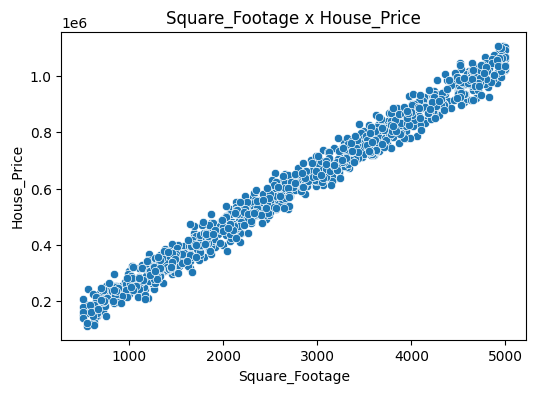

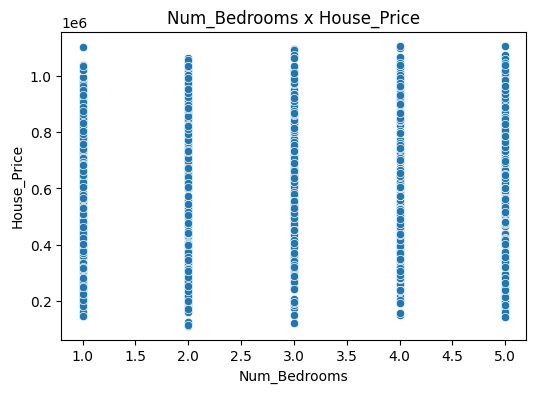

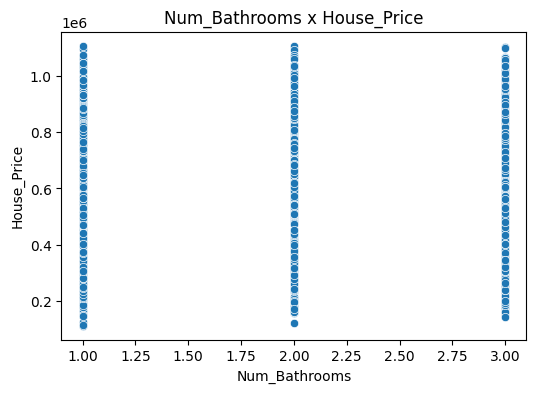

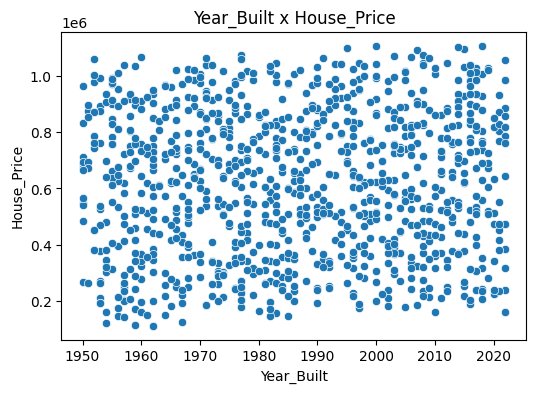

In [5]:

# Relação entre algumas variáveis e o preço
target = 'House_Price'
num_cols = [coluna for coluna in df.columns if coluna != 'House_Price']


print("As variáveis numéricas usadas na análise são:\n")
print(num_cols, "\n")

for col in num_cols[:4]:
    plt.figure(figsize=(6,4))
    sns.scatterplot(x=df[col], y=df[target])
    plt.title(f'{col} x {target}')
    plt.show()

In [6]:
# === 4. Pré-processamento ===

cat_cols = df.select_dtypes(include=['object']).columns
if len(cat_cols) > 0:
    le = LabelEncoder()
    for col in cat_cols:
        df[col] = le.fit_transform(df[col].astype(str))

# Separar X e y
X = df.drop(columns=[target])
y = df[target]

# Padronizar variáveis numéricas
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print('Pré-processamento concluído!')

Pré-processamento concluído!


In [11]:
# === 5. Treino e Teste dos Modelos ===
modelos = {
    'LinearRegression': LinearRegression(),
    'RandomForest': RandomForestRegressor(random_state=42)
}

resultados = {}
total_runs = 30

for nome, modelo in modelos.items():
    erros, r2s = [], []
    for _ in range(total_runs):
        X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2,  random_state=42)
        modelo.fit(X_train, y_train)
        y_pred = modelo.predict(X_test)
        erros.append(np.sqrt(mean_squared_error(y_test, y_pred)))
        r2s.append(r2_score(y_test, y_pred))
    resultados[nome] = {
        'RMSE_medio': np.mean(erros),
        'RMSE_desvio': np.std(erros),
        'R2_medio': np.mean(r2s),
        'R2_desvio': np.std(r2s)
    }

resultados_df = pd.DataFrame(resultados).T
print('\n Resultados após 30 execuções:')
display(resultados_df)


 Resultados após 30 execuções:


,RMSE_medio,RMSE_desvio,R2_medio,R2_desvio
LinearRegression,10071.484424,1.818989e-12,0.998426,0.0
RandomForest,19917.085110,0.000000e+00,0.993846,0.0


In [8]:
# === 6. Escolher o melhor modelo e exportar ===
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

melhor_modelo_nome = resultados_df['RMSE_medio'].idxmin()
melhor_modelo = modelos[melhor_modelo_nome]

print(f"\nTreinando novamente o melhor modelo: {melhor_modelo_nome}")

# Criar pipeline com o scaler embutido
pipeline = make_pipeline(StandardScaler(), melhor_modelo)

# Treinar pipeline com dados brutos (sem X_scaled)
pipeline.fit(X, y)

# Exportar tudo junto
dump(pipeline, f'{melhor_modelo_nome}.joblib')
print(f"\nModelo '{melhor_modelo_nome}' exportado com scaler embutido!")



Treinando novamente o melhor modelo: LinearRegression

Modelo 'LinearRegression' exportado com scaler embutido!


### Teste filtrando variáveis

 Analisando importância das variáveis...

Correlação de cada variável com o preço da casa:



House_Price             1.000000
Square_Footage          0.991261
Lot_Size                0.160412
Garage_Size             0.052133
Year_Built              0.051967
Num_Bedrooms            0.014633
Num_Bathrooms          -0.001862
Neighborhood_Quality   -0.007770
Name: House_Price, dtype: float64

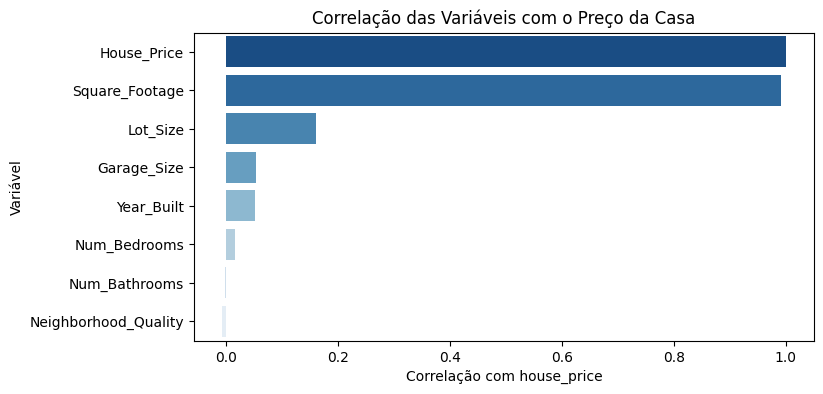

O modelo LinearRegression não fornece importâncias diretas (ex: regressão linear).

🔍 Variáveis mais correlacionadas com o preço (|corr| > 0.5):
['House_Price', 'Square_Footage']


In [ ]:
# === 7. Análise de Importância das Variáveis ===

print(" Analisando importância das variáveis...\n")

#  Correlação das variáveis com o preço
corr = df.corr(numeric_only=True)['House_Price'].sort_values(ascending=False)
print("Correlação de cada variável com o preço da casa:\n")
display(corr)

plt.figure(figsize=(8, 4))
sns.barplot(x=corr.values, y=corr.index, palette="Blues_r")
plt.title("Correlação das Variáveis com o Preço da Casa")
plt.xlabel("Correlação com house_price")
plt.ylabel("Variável")
plt.show()

# Importância das variáveis 
if hasattr(melhor_modelo, "feature_importances_"):
    importances = melhor_modelo.feature_importances_
    features = X.columns
    imp_df = pd.DataFrame({"Variável": features, "Importância": importances})
    imp_df = imp_df.sort_values("Importância", ascending=False)

    print("Importância das variáveis no modelo:\n")
    display(imp_df)

    plt.figure(figsize=(8, 4))
    sns.barplot(x="Importância", y="Variável", data=imp_df, palette="viridis")
    plt.title(f"Importância das Variáveis no Modelo {melhor_modelo_nome}")
    plt.show()
else:
    print(f"O modelo {melhor_modelo_nome} não fornece importâncias diretas (ex: regressão linear).")

#  Análise automática: variáveis mais relevantes
print("\n🔍 Variáveis mais correlacionadas com o preço (|corr| > 0.5):")
variaveis_relevantes = corr[abs(corr) > 0.5].index.tolist()
print(variaveis_relevantes if len(variaveis_relevantes) > 0 else "Nenhuma variável com correlação forte.")


In [ ]:
# === Teste com variáveis mais relevantes ===
variaveis_relevantes = ['Square_Footage', 'Lot_Size']  
X_relevantes = df[variaveis_relevantes]
y = df['House_Price']

X_train, X_test, y_train, y_test = train_test_split(X_relevantes, y, test_size=0.2, random_state=42)
modelo_simples = LinearRegression()
modelo_simples.fit(X_train, y_train)
y_pred = modelo_simples.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"📉 RMSE (modelo reduzido): {rmse:.2f}")
print(f"📈 R² (modelo reduzido): {r2:.3f}")


📉 RMSE (modelo reduzido): 27185.35
📈 R² (modelo reduzido): 0.989


### ✅ Conclusão
O modelo com melhor desempenho foi automaticamente exportado usando **joblib**.